## load packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_selection import VarianceThreshold

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Input

## Preprocess the data


In [ ]:
file_path = "/content/drive/MyDrive/DTSC Big Data/BigData/amazon_reviews_us_Electronics_v1_00.tsv" #bh amazon electronics data file path
data = pd.read_csv(file_path,  sep='\t', on_bad_lines='skip') # load and read dataset
data.describe() # summary data

NameError: ignored

In [ ]:
data.head() # preview dataset

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [ ]:
data.info() # columns and datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091024 entries, 0 to 3091023
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 353.7+ MB


In [ ]:
data['product_id'].value_counts()[:15]

B003L1ZYYM    15334
B0002L5R78    11166
B003EM8008     9766
B0012S4APK     9359
B0001FTVEK     8793
B000WYVBR0     7835
B0019EHU8G     7586
B00F5NE2KG     6688
B004QK7HI8     6536
B00D5Q75RC     6062
B00316263Y     5813
B0052SCU8U     5756
B001GTT0VO     5580
B002MAPT7U     5295
B003WGRUQQ     5072
Name: product_id, dtype: int64

In [ ]:
review=pd.DataFrame(data.groupby('star_rating').size().sort_values(ascending=False).rename('No of reviews').reset_index())
review.head()

,star_rating,No of reviews
0,5,1779371
1,4,536417
2,1,357817
3,3,238387
4,2,179032


# Feature extractor

## select review_body coloum

In [ ]:
data_n = data[['star_rating' , 'review_body' , 'review_headline' , 'customer_id']]
data_n=data_n.dropna()
data_n.head()

,star_rating,review_body,review_headline,customer_id
0,5,As described.,Five Stars,41409413
1,5,It works as advertising.,It works as advertising.,49668221
2,5,Works pissa,Five Stars,12338275
3,1,Did not work at all.,One Star,38487968
4,5,Works well. Bass is somewhat lacking but is pr...,Overall pleased with the item,23732619


In [ ]:
check =  data_n[data_n["review_body"].isnull()]
check.head()

,star_rating,review_body,review_headline,customer_id


In [ ]:
data_n = data_n.sample(n=10000) # randomly select 10000 rows of data as sample
print(len(data_n))

10000


In [ ]:
actualrating = data_n[(data_n['star_rating'] == 1) | (data_n['star_rating'] == 5)]
actualrating.shape

(6942, 4)

In [ ]:
y = actualrating['star_rating']
x = actualrating['review_body'].reset_index()

In [ ]:
len(y)

6942

In [ ]:
X = x['review_body']
print(X)

0       We bought this alarm clock to replace the clun...
1       Very cheap. The buttons do not do what they ar...
2       Works just fine.  Now my wife and I can loose ...
3       What great deals you guys have.  I will deffen...
4       I've occasionally tried a different brand of U...
                              ...                        
6937    Paired it with the Bose Soundlink speaker and ...
6938    Great product to protect our outdoor 32&#34; t...
6939    didn't work for me. Thought it might be my tv,...
6940    now all we have to do is learn to use the &#34...
6941    Working flawless with my iPod Classic 80GB. A ...
Name: review_body, Length: 6942, dtype: object


In [ ]:
print(len(X))


6942


## Continuing Normalization

In [ ]:
import string
from nltk.corpus import stopwords
# stop=set(stopwords.words('english'))
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [ ]:
tokens = X[0].split()
print(tokens)

['We', 'bought', 'this', 'alarm', 'clock', 'to', 'replace', 'the', 'clunky', 'old', 'one.', 'Man', 'what', 'a', 'difference.', 'It', 'is', 'easy', 'for', 'both', 'my', 'wife', 'and', 'I', 'to', 'look', 'at', 'the', 'time', 'with', 'the', 'LED', 'display', 'on', 'the', 'ceiling', 'at', 'night.']


In [ ]:
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."
print(text_process(sample_text))


['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


# Feature vectors

## Vectorization

similiar to the idea of Shingling: Converts a document into a set representation (Boolean vector)

Here we use SciKit Learn’s CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.

For example: 

word count/message| Message 1	| Message 2 | Message 3 | ......... | Message n |
------------------|------------|-----------|----------|-----------|-----------|
Word 1 Count      | 0          | 1         | 0        | 0         | 2         |
Word 2 Count      | 1          | 0         | 0        | 0         | 0         |
Word 3 Count      | 1          | 2         | 1        | 1         | 1         |
............      | 1          | 1         | 0        | 1         | 0         |
Word n Count      | 1          | 1         | 1        | 0         | 1         |

Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# return a vector array
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

 bow = bag of words

In [ ]:
len(bow_transformer.vocabulary_)

21314

In [ ]:
review_66 = X[66]

In [ ]:
bow_66 = bow_transformer.transform([review_66])
bow_66


<1x21314 sparse matrix of type '<class 'numpy.int64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [ ]:
print(bow_66)

  (0, 2700)	2
  (0, 3611)	1
  (0, 4839)	1
  (0, 5955)	1
  (0, 6105)	1
  (0, 7033)	1
  (0, 7622)	1
  (0, 7935)	3
  (0, 7944)	1
  (0, 7990)	1
  (0, 8282)	1
  (0, 9322)	1
  (0, 9330)	1
  (0, 9334)	3
  (0, 10673)	1
  (0, 10717)	2
  (0, 11204)	1
  (0, 12294)	1
  (0, 13168)	1
  (0, 13426)	1
  (0, 13438)	1
  (0, 13678)	1
  (0, 14372)	1
  (0, 14380)	1
  (0, 14440)	1
  (0, 14736)	2
  (0, 15085)	1
  (0, 15115)	1
  (0, 15248)	1
  (0, 15300)	1
  (0, 16090)	1
  (0, 17105)	2
  (0, 17740)	1
  (0, 17832)	1
  (0, 18019)	1
  (0, 18343)	1
  (0, 18515)	1
  (0, 18517)	1
  (0, 18911)	1
  (0, 19108)	1
  (0, 19335)	1
  (0, 19737)	1
  (0, 20129)	1
  (0, 20436)	1
  (0, 20469)	1


In [ ]:
bow_66.getnnz() 

45

total number of the unique words in review body no. 66, after removing stopwords. 4 of them reqeat 2 times, and 2 of them reqeat 3 times.



In [ ]:
print(bow_transformer.get_feature_names_out()[7935])

antenna


In [ ]:
X = bow_transformer.transform(X)

In [ ]:
print('Shape of Sparse Matrix: ', X.shape)

Shape of Sparse Matrix:  (6942, 21314)


In [ ]:
print('Amount of Non-Zero occurences: ', X.nnz)

Amount of Non-Zero occurences:  183650


In [ ]:
sparsity = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('sparsity: {}'.format(sparsity))
#non zero/total

sparsity: 0.12411988425011464


after count, there about 12.4% of the entire metrix are zeros.

In [ ]:
#Lets start training the model
from sklearn.model_selection import train_test_split
#using 30% of the data for testing, this will be revised once we do not get the desired accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)

In [ ]:
y_test.shape, X_test.shape ,X_train.shape ,y_train.shape


((2083,), (2083, 21314), (4859, 21314), (4859,))

# Fitting simple Classfier model to the training set

## Training in different classifier 

to find the best fitting classifier for this dataset

* Naive Bayes Classifier
* Support Vector Machine
* K Neighbors Classifier
* Gradient Boosting Classifier


### Naive Bayes Classifier
[Text Classification using Naive Bayes](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf)

[Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)



In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

NameError: ignored

In [ ]:
preds = nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
nb.score(X_train, y_train)

* precision = TP / TP + FP
* recall = TP / TP + FN
* S = 1-(1-s^r)b ---false positive
* S = (1-s^r)b ---false negative


### support vector machine 

SVM maps training examples to points in space so as to maximise the width of the gap between the two categories. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

[SVMs](https://scikit-learn.org/stable/modules/svm.html#:~:text=Support%20vector%20machines%20(SVMs)%20are,than%20the%20number%20of%20samples.)

SVC for binary classification

The advantages of support vector machines are:

* Effective in high dimensional spaces.

* Still effective in cases where number of dimensions is greater than the number of samples.

In [ ]:
from sklearn.svm import SVC
clf = SVC() # classfiyer
clf.fit(X_train, y_train) 
predsvm=clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, predsvm))
predsvm=clf.predict(X_test)
clf.score(X_train,y_train)

[[ 151  202]
 [  35 1695]]


              precision    recall  f1-score   support

           1       0.91      0.29      0.45       353
           5       0.87      0.99      0.93      1730

    accuracy                           0.88      2083
   macro avg       0.89      0.64      0.69      2083
weighted avg       0.88      0.88      0.85      2083



0.9450504218975098

### KNeighborsClassifier

[Classifier implementing the k-nearest neighbors vote.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

[Neighbors-based classification](hhttps://scikit-learn.org/stable/modules/neighbors.html#classification) ,Classification is computed from a simple majority vote of the nearest neighbors of each point.

The *k*-neighbors classification in KNeighborsClassifier is the most commonly used technique. The optimal choice of the value *k* is highly data-dependent: in general a larger *k* suppresses the effects of noise, but makes the classification boundaries less distinct.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 

KNeighborsClassifier(n_neighbors=3)

In [ ]:
predsknn=neigh.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predsknn))
print('\n')
print(classification_report(y_test, predsknn))
neigh.score(X_train,y_train)

[[ 174  179]
 [  23 1707]]


              precision    recall  f1-score   support

           1       0.88      0.49      0.63       353
           5       0.91      0.99      0.94      1730

    accuracy                           0.90      2083
   macro avg       0.89      0.74      0.79      2083
weighted avg       0.90      0.90      0.89      2083



0.9010084379501955

### GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model.fit(X_train, y_train)
predicted= model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predicted))
print('\n')
print(classification_report(y_test, predicted))
model.score(X_train,y_train)

[[ 167  186]
 [  53 1677]]


              precision    recall  f1-score   support

           1       0.76      0.47      0.58       353
           5       0.90      0.97      0.93      1730

    accuracy                           0.89      2083
   macro avg       0.83      0.72      0.76      2083
weighted avg       0.88      0.89      0.87      2083



0.9121218357686767

# Predicting the Result

In [ ]:
actualrating['review_body'].head()

1585370    We bought this alarm clock to replace the clun...
596204     Very cheap. The buttons do not do what they ar...
236132     Works just fine.  Now my wife and I can loose ...
2264764    What great deals you guys have.  I will deffen...
2082293    I've occasionally tried a different brand of U...
Name: review_body, dtype: object

In [ ]:
positive_review = actualrating['review_body'][2264764]
positive_review

"What great deals you guys have.  I will deffenety use these for my school, and for my own dvds.  I'm buying again!"

In [ ]:
positive_review_transformed = bow_transformer.transform([positive_review])
nb.predict(positive_review_transformed)[0]

5

In [ ]:
clf.predict(positive_review_transformed)[0]

5

In [ ]:
actualrating['review_body'].tail()

223898     Paired it with the Bose Soundlink speaker and ...
324460     Great product to protect our outdoor 32&#34; t...
1493144    didn't work for me. Thought it might be my tv,...
1429900    now all we have to do is learn to use the &#34...
2920456    Working flawless with my iPod Classic 80GB. A ...
Name: review_body, dtype: object

In [ ]:
positive_review = actualrating['review_body'][324460]
positive_review

'Great product to protect our outdoor 32&#34; television especially since we did not go with a true outdoor television.  This cover should protect the flat screen television that we installed outside under our patio.<br />Highly Recommend!!'

In [ ]:
positive_review_transformed = bow_transformer.transform([positive_review])
model.predict(positive_review_transformed)[0]

5

In [ ]:
negative_review = data_n['review_body'][1493144]
print(negative_review)

didn't work for me. Thought it might be my tv, but didn't work from other audio outputs either. No LED indicators or anything to indicate it's even powering.


In [ ]:
negative_review_transformed = bow_transformer.transform([negative_review])
nb.predict(negative_review_transformed)[0]

1

In [ ]:
clf.predict(negative_review_transformed)[0]

1

# Visulasation

# Citation
* [Learning to Classify Text](https://www.nltk.org/book/ch06.html)
* [NLP with Python](https://rpubs.com/pjozefek/669929)
* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)
* [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* Géron, Aurélien, and Rebecca Demarest. “3. Classification/ Performance Measures/ Precision and Recall.” Hands-on Machine Learning with Scikit-Learn and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, O'Reilly, 2019. 

# Data Source

[US REVIEWS DATASET](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt)

# stop here=======================================================
# stop here=======================================================
# stop here=======================================================
# stop here=======================================================
# stop here=======================================================

[ref](https://www.kaggle.com/code/lele1995/amazon-reviews-sentiment-analysis) 

[ref2](https://www.kaggle.com/code/aherparesh/sentiment-analysis-on-amazon-product-rnn-97-acc/notebook)

In [ ]:
#we need to have a label for 
# lets have a label which group the stars into two groups, 1 for good, 0 for bad 
# so anything more than 3 , 3 being neutral is good, rest bad
# data['label'] = ['1' if star_rating > 3 else '0' for star_rating in data['star_rating]];
data_n['label'] = ['1' if star >= 3 else '0' for star in data_n['star_rating']];

In [ ]:
data_n

,star_rating,review_body,review_headline,customer_id,label
889375,5,Already bought 2 of these. Best in ear headpho...,Best in ear headphones,15297678,1
2960384,5,Over the past 10 or 15 years I've probably own...,I've tried lots of wireless headphones/this is...,51178267,1
632679,5,Awesome quality awesome sound worth the money!,Get them!,992232,1
2830098,5,"I have had this unit for close to a month, and...",Great Product for the money,39978804,1
1027655,2,Have to say I was very disappointed with the b...,Not a keeper,18626320,0
...,...,...,...,...,...
648286,5,Bought for a friend for Christmas she loves them,Five Stars,42909283,1
1327781,1,"I bought this in 2012, worked great...but I pr...",Not Great-Beware,18055047,0
987109,1,The only good experience I had using this prod...,did not work. disappointed to say the least,22142952,0
1380711,5,It's a cheap HDMI cable that doesn't look or f...,It's only cheap in price.,52136697,1


In [ ]:
data_n.tail()

,star_rating,review_body,review_headline,customer_id,label
648286,5,Bought for a friend for Christmas she loves them,Five Stars,42909283,1
1327781,1,"I bought this in 2012, worked great...but I pr...",Not Great-Beware,18055047,0
987109,1,The only good experience I had using this prod...,did not work. disappointed to say the least,22142952,0
1380711,5,It's a cheap HDMI cable that doesn't look or f...,It's only cheap in price.,52136697,1
2249305,5,The headphone jack covers are great quality an...,Good Product,10052252,1


In [ ]:
reviews = data_n['review_body']
labels = data_n['label']

In [ ]:
print(len(reviews))

10000


In [ ]:
print(len(labels))


10000


In [ ]:
reviews[2249305]

'The headphone jack covers are great quality and not to mention the wife was happy as a bug in a rug too!'

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
import regex as re
def clean_document(doco):
    punctuation = string.punctuation
    punc_replace = ''.join([' ' for s in punctuation])
    doco_link_clean = re.sub(r'http\S+', '', doco)
    doco_clean_and = re.sub(r'&\S+', '', doco_link_clean)
    doco_clean_at = re.sub(r'@\S+', '', doco_clean_and)
    doco_clean = doco_clean_at.replace('-', ' ')
    doco_alphas = re.sub(r'\W +', ' ', doco_clean)
    trans_table = str.maketrans(punctuation, punc_replace)
    doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')])
    doco_clean = doco_clean.split(' ')
    p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
    doco_clean = [word.lower() for word in doco_clean if len(word) > 2]
    doco_clean = ([i for i in doco_clean if i not in stop])
#     doco_clean = [spell(word) for word in doco_clean]
#     p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
#     doco_clean = ([spell(k) for k in doco_clean])
    return doco_clean

In [ ]:
# Generate a cleaned reviews array from original review texts
review_cleans = [clean_document(doc) for doc in reviews];
sentences = [' '.join(r) for r in review_cleans ]

In [ ]:
data_n.head()

,star_rating,review_body,review_headline,customer_id,label
889375,5,Already bought 2 of these. Best in ear headpho...,Best in ear headphones,15297678,1
2960384,5,Over the past 10 or 15 years I've probably own...,I've tried lots of wireless headphones/this is...,51178267,1
632679,5,Awesome quality awesome sound worth the money!,Get them!,992232,1
2830098,5,"I have had this unit for close to a month, and...",Great Product for the money,39978804,1
1027655,2,Have to say I was very disappointed with the b...,Not a keeper,18626320,0


In [ ]:
print(sentences[3])

unit close month love features suggest read manual attempting connect yes resist guy urge fairly simple setup sumsung hlt 5075s directv dvr sony disk player harmony remote biggest surprise harmony already codes except ipod took sluething manual button setup able use one hdmi cable cable box vsx 1019ah one cable samsung great one glitch need run rca audio directv box receiver channels receiver times misses automatically switching hdmi cable sat audio fix clicking sat sound click hdmi get picture sound using microphone balance setup speakers easy provided find receiver button remote also different audio setups receiver makes switching daytime listening watching movie listening ipod even old breeze basic settings like sound wonderful receiver lot features audio video settings play browse manual couple times use volume max setting saves turn unit kids using ipod feature great cable included connect front use remote make selections happy unit update audio march directv dvr box died received

In [ ]:
print(reviews[2830098])

I have had this unit for close to a month, and love the features.  Suggest you read the manual before attempting to connect, yes resist the guy urge.  I have a fairly simple setup, Sumsung HLT-5075S, Directv with DVR, Sony 5 disk player and a Harmony remote.  My biggest surprise was the Harmony already had the codes, except Ipod took some sluething and manual button setup.  Being able to use one HDMI cable from the cable box into the VSX-1019ah-k and one cable into the Samsung TV, was great.  One glitch, I did need to run an RCA audio from Directv box into the receiver for some channels, and the receiver at times misses automatically switching from HDMI cable to the tv/sat audio.  My fix is clicking tv/sat for sound, then click the HDMI to get the picture and sound.  Using the microphone to balance and setup the speakers is easy, provided you find the \\"receiver\\" button on remote.  Also having 6 different audio setups on the receiver makes switching from daytime listening, or watchi

In [ ]:
reviews.shape
# sentences.shape


(10000,)

In [ ]:
#Keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [ ]:
import numpy as np

text_sequences = np.array(tokenizer.texts_to_sequences(sentences))
sequence_dict = tokenizer.word_index
word_dict = dict((num, val) for (val, num) in sequence_dict.items())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(text_sequences)

[list([325, 18, 57, 29, 14, 3, 532, 44, 72, 113, 657, 60, 120, 29])
 list([528, 122, 262, 419, 125, 275, 14, 1714, 422, 110, 3017, 7059, 138, 19, 200, 1665, 215, 400, 69, 104, 275, 235, 2095, 1148, 188, 316, 11, 191, 69, 32, 297, 61, 3017, 1665, 69, 138, 308, 189, 84, 434, 266, 5927, 71, 96, 413, 191, 1715, 53, 972, 4628, 1, 344, 17, 345, 96, 7, 82, 93, 57, 53, 8, 62, 597, 70, 933, 275, 14, 79, 9430, 3184, 275, 195, 57, 4, 110, 7, 82, 413, 191, 1132, 703, 298, 236, 110, 1084, 136, 1462, 3185, 739, 82, 111, 1317, 79, 920, 1434, 3880, 163, 620, 1226, 1169, 1462, 2423, 14, 232, 227, 102, 38, 943, 1462, 71, 66, 8, 229, 159, 166, 102, 166, 2532, 39, 244, 7, 1496, 1085, 2252, 39, 317, 53, 3388, 213, 811, 33, 275, 14, 64, 17, 115, 727, 75, 308, 244, 362, 333, 1099, 239, 38, 4210, 2424, 75, 300, 709, 611, 184, 218, 1980, 41, 944, 275, 195, 37, 9431, 153, 275, 235, 3389, 2738, 219, 363, 17, 298, 189, 1526, 3880, 2335, 413, 138, 1716])
 list([211, 6, 211, 1, 160, 90]) ...
 list([3, 341, 32, 9, 8

In [ ]:
print(sequence_dict)

{'sound': 1, 'great': 2, 'good': 3, 'one': 4, 'use': 5, 'quality': 6, 'would': 7, 'like': 8, 'product': 9, 'well': 10, 'get': 11, 'price': 12, 'works': 13, 'headphones': 14, 'work': 15, 'cable': 16, 'time': 17, 'bought': 18, 'music': 19, 'really': 20, 'much': 21, 'also': 22, 'even': 23, 'better': 24, 'buy': 25, 'little': 26, 'easy': 27, 'player': 28, 'ear': 29, 'speaker': 30, 'speakers': 31, 'using': 32, 'used': 33, 'set': 34, 'nice': 35, 'got': 36, 'radio': 37, 'back': 38, 'battery': 39, 'recommend': 40, 'still': 41, 'could': 42, 'need': 43, 'bass': 44, 'unit': 45, 'love': 46, 'first': 47, 'two': 48, 'remote': 49, 'new': 50, 'way': 51, 'power': 52, 'system': 53, 'worked': 54, 'audio': 55, 'small': 56, 'best': 57, 'ipod': 58, 'volume': 59, 'right': 60, 'device': 61, 'want': 62, 'fit': 63, 'long': 64, 'amazon': 65, 'thing': 66, 'pair': 67, 'fine': 68, 'problem': 69, 'around': 70, 'another': 71, 'make': 72, 'looking': 73, 'without': 74, 'batteries': 75, 'purchased': 76, 'perfect': 77, 'h

In [ ]:
reviews_encoded = [];
for i,review in enumerate(review_cleans):
    reviews_encoded.append([sequence_dict[x] for x in review]);

(array([ 30., 345., 399., 291., 350., 264., 211., 245., 252., 297., 338.,
        387., 349., 358., 325., 302., 240., 208., 200., 212., 166., 163.,
        145., 280.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Patch objects>)

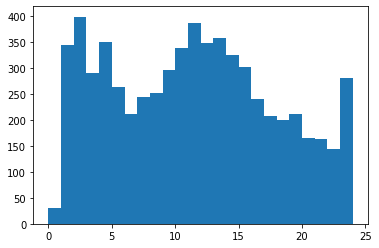

In [ ]:
lengths = [len(x) for x in reviews_encoded]
plt.hist(lengths, bins=range(25))

In [ ]:
print(reviews_encoded[135])


[124, 765, 200, 8, 4233, 1377, 951, 99, 116, 144, 1120, 7104, 683, 50, 313, 1120, 407, 201, 1120, 1120, 200, 7, 15, 99, 365, 23, 486, 71, 351, 106, 99, 2341, 952, 1635, 759, 15, 68, 115, 270, 214, 210, 561, 567, 32, 5948, 4, 29, 117, 72, 5, 6, 685, 99, 5948, 1822, 2, 200, 11, 685, 951, 5948, 1536, 6, 146, 3029, 2, 136, 25, 71, 113, 1439, 109, 972, 164, 84, 5, 103, 8, 7104, 349, 1503]


In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_cap =8;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')

In [ ]:
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

In [ ]:
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

In [ ]:
X = X[random_posits];
Y = Y[random_posits];

In [ ]:
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

In [ ]:
X_train, Y_train = X[:train_cap], Y[:train_cap]
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap]
X_test1, Y_test1 = X[dev_cap:], Y[dev_cap:]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import eval
from tensorflow.keras.optimizers import Adam # - Works
from keras.layers import LSTM
from keras.layers.embeddings import Embedding


model1 = Sequential();
model1.add(Embedding(len(word_dict)+1, max_cap, input_length=max_cap));
#adding a LSTM layer of dim 1--
model1.add(LSTM(200, return_sequences=True));
model1.add(LSTM(200, return_sequences=False));
#adding a dense layer with activation function of relu
model1.add(Dense(75, activation='relu'));#best 50,relu
#adding the final output activation with activation function of softmax
model1.add(Dense(2, activation='sigmoid'));
print(model1.summary());
optimizer = Adam(learning_rate=0.0001);

model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model and run it for 5 epochs
model1.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_dev, Y_dev))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 8, 8)              139104    
                                                                 
 lstm_29 (LSTM)              (None, 8, 200)            167200    
                                                                 
 lstm_30 (LSTM)              (None, 200)               320800    
                                                                 
 dense_21 (Dense)            (None, 75)                15075     
                                                                 
 dense_22 (Dense)            (None, 2)                 152       
                                                                 
Total params: 642,331
Trainable params: 642,331
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
532/532 [=======================

In [ ]:
score = model1.evaluate(X_test1, Y_test1)
print("Test accuracy: %0.4f%%" % (score[1]*100))

22/22 [==============================] - 3s 86ms/step - loss: 0.3748 - accuracy: 0.8557
Test accuracy: 85.5714%


#############################################

#############################################

#############################################

#############################################

#############################################

#############################################

#############################################

In [ ]:
from pandas.core.frame import DataFrame
data_sel = data.drop(['marketplace', 'product_category','vine','helpful_votes','total_votes'], axis=1)

In [ ]:
data_sel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091024 entries, 0 to 3091023
Data columns (total 10 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   customer_id        int64 
 1   review_id          object
 2   product_id         object
 3   product_parent     int64 
 4   product_title      object
 5   star_rating        int64 
 6   verified_purchase  object
 7   review_headline    object
 8   review_body        object
 9   review_date        object
dtypes: int64(3), object(7)
memory usage: 235.8+ MB


In [ ]:
data_num = data_sel.select_dtypes(exclude=["object"])
data_num.head()

,customer_id,product_parent,star_rating
0,41409413,112201306,5
1,49668221,734576678,5
2,12338275,614448099,5
3,38487968,72265257,1
4,23732619,308169188,5


In [ ]:
from pandas.core.algorithms import unique
print(len(unique(data_num['product_parent'])))

166173


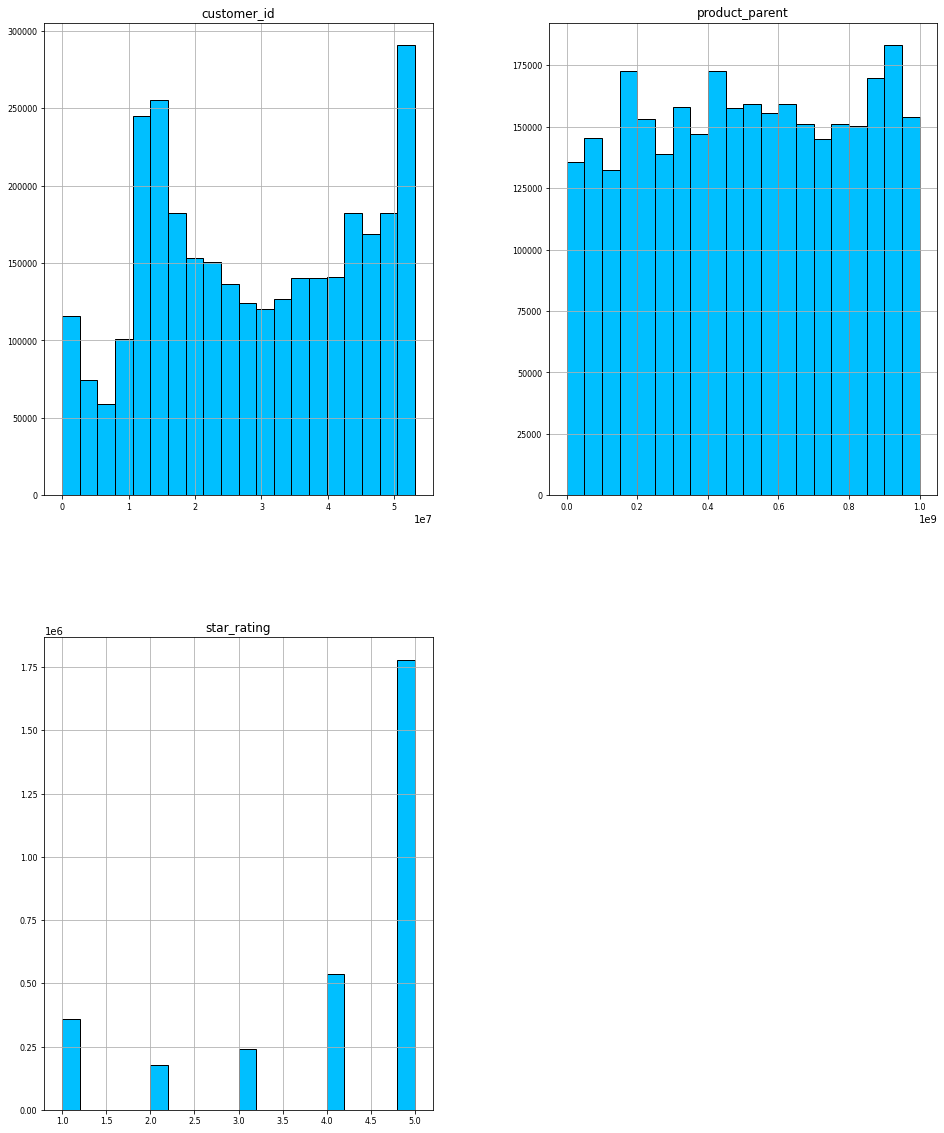

In [ ]:
# Plot the distribution of all the numerical data
fig_ = data_num.hist(figsize=(16, 20), 
                         bins=20, 
                         color="deepskyblue",
                         edgecolor="black", 
                         xlabelsize=8, ylabelsize=8)